# EDA Version 1
In this notebook, I will do some simple EDA to understand the distribution of transaction data in our dataset. Primarily, this notebook will be looking at the value of each transaction and detecting positive outliers. This can contribute to a simple flagging system that will send a pop up alert when an extremely high transaction is completeted. 

Because the MySQL server is locally hosted from my laptop, much of this file will only be used on the laptop.

See EDAv2 for further testing using a written dataset with the first 100,000 transactions

In [2]:
import mysql.connector
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [3]:
db_password = os.environ.get('DB_PASSWORD')

# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=db_password,  # Use your MySQL password
    database="blockchain_fraud"
)

# Fetch all transactions
query = "SELECT * FROM transactions;"
df = pd.read_sql(query, conn)

# Close connection
conn.close()


/var/folders/cj/bg2z73t51ts_ftlnkpg413qm0000gn/T/ipykernel_83526/1115493299.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [4]:
# Fix the id column
df.drop(columns=['id'], inplace=True)
df.rename_axis('id', axis=1,inplace=True)

In [5]:
df.describe()

id,value,gas_used,gas_price,timestamp
count,1.000465e+06,1.000465e+06,1.000465e+06,1000465
mean,1.277905e+00,2.179677e+05,2.739295e+00,2025-02-16 05:42:16.733955072
min,0.000000e+00,2.100000e+04,6.081562e-01,2025-02-14 10:16:10
25%,0.000000e+00,2.100000e+04,1.000000e+00,2025-02-15 12:12:16
50%,0.000000e+00,7.500000e+04,1.424929e+00,2025-02-16 17:24:07
75%,9.923580e-03,2.071280e+05,2.584189e+00,2025-02-17 00:11:38
max,5.015624e+04,3.492168e+07,2.786000e+05,2025-02-17 06:06:35
std,1.084117e+02,8.134755e+05,2.794521e+02,NaN


In [18]:
df.to_csv('transactions.csv', index=False)

Here, we can see that the value of most transactions is relatively low, at around 1-2 ether. The maximum value (as of last check) was 33183 ether, which is a crazy high volume of ether. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000465 entries, 0 to 1000464
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   hash       1000465 non-null  object        
 1   sender     1000465 non-null  object        
 2   recipient  1000465 non-null  object        
 3   value      1000465 non-null  float64       
 4   gas_used   1000465 non-null  int64         
 5   gas_price  1000465 non-null  float64       
 6   timestamp  1000465 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 53.4+ MB


Non NaN values which is a good sign.

Lets check for duplicate data on our hash, since that should be a unique key.

In [7]:
df.duplicated(subset=['hash']).sum()

0

No duplicates, which is also good

Lets check the distributions of some of our features.

In [8]:
def plot_log_scatter(index, values, title, xlabel, ylabel):
    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 6))

    plt.scatter(index,
                values,
                linestyle='-', 
                marker='o',
                s=1,
                alpha=0.5, 
                color='black',
                label="Transaction Value")

    # Use log scale for better visualization of outliers
    plt.yscale("log")

    plt.xticks(np.linspace(0, len(values), num=10, dtype=int))

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight='bold')

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()

    plt.show()


/Users/seelyfrank/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


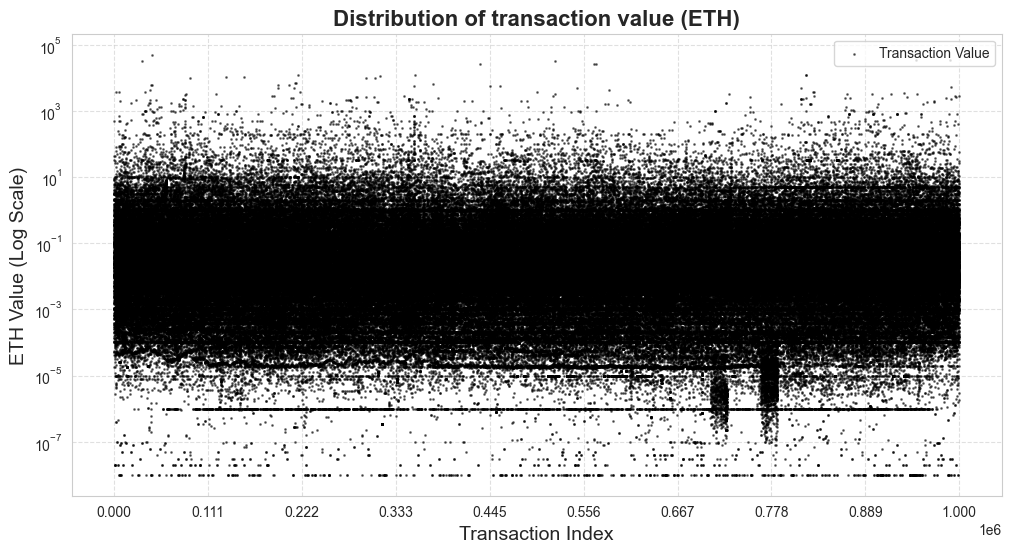

In [9]:
plot_log_scatter(df.index,
                df['value'],
                'Distribution of transaction value (ETH)',
                'Transaction Index',
                'ETH Value (Log Scale)')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


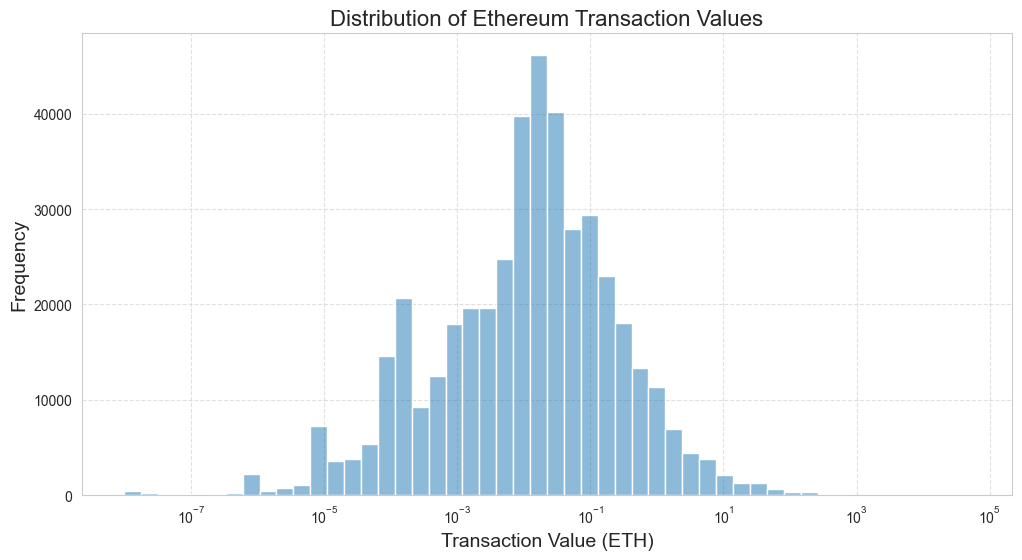

In [10]:
plt.figure(figsize=(12, 6))

sns.histplot(df['value'], bins=50, log_scale=True, kde=True)

plt.xlabel("Transaction Value (ETH)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Ethereum Transaction Values", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


The values of these transactions in ETH is actually fairly normal, and the mass seems to lean a bit heavier on the right side than the left side. We can see that there are actually just as many outliers on the left (possibly more) than there are on the right.

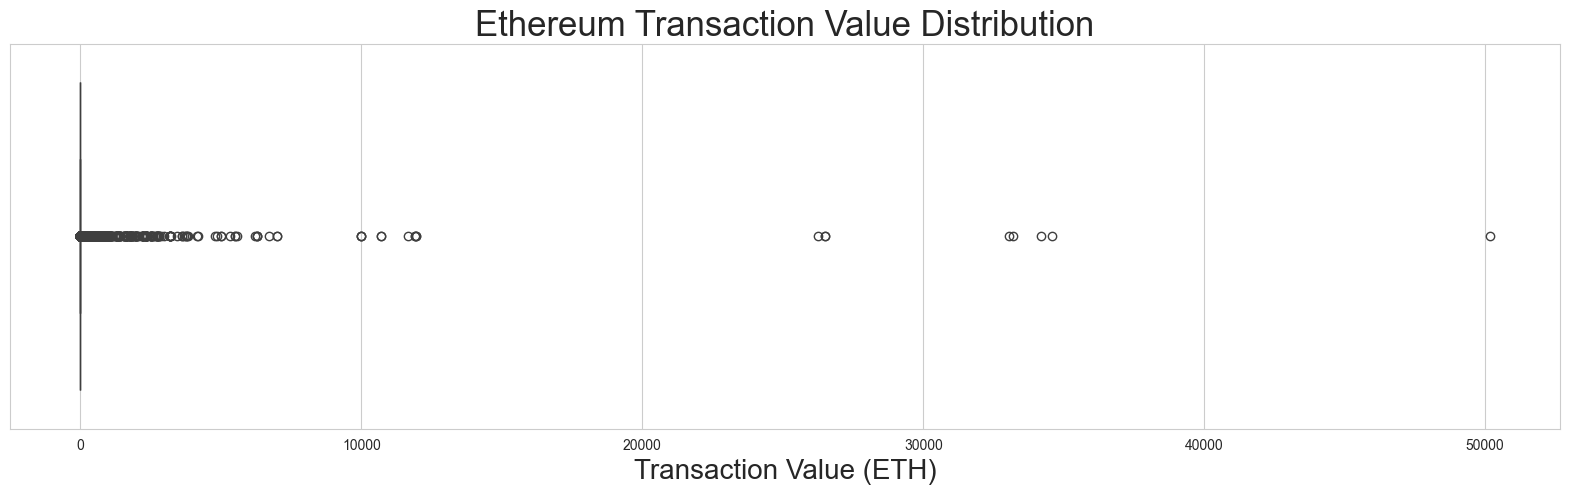

In [11]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=df['value'], showfliers=True)

plt.xlabel("Transaction Value (ETH)", fontsize=20)
plt.title("Ethereum Transaction Value Distribution", fontsize=25)
plt.show()

Lets fine out where our outliers are (for the larger transactions)

In [12]:
def find_outliers(data, threshhold):
    zscores = stats.zscore(data)
    return np.where(zscores >= threshhold)[0]

outliers_gt_2 = find_outliers(df['value'], 2)
outliers_gt_3 = find_outliers(df['value'], 3)

outliers_gt_2_val = df['value'][outliers_gt_2].sort_values()
outliers_gt_3_val = df['value'][outliers_gt_3].sort_values()

In [13]:
print(f'Number of transactions with a Z-score of 2 or higher: {len(outliers_gt_2_val)}')
print('--------------------------------------------------------------------------------')
print(f'Values that are greater than a Z-score of 2:\n {outliers_gt_2_val}')

Number of transactions with a Z-score of 2 or higher: 605
--------------------------------------------------------------------------------
Values that are greater than a Z-score of 2:
 596417      218.372315
251042      218.841528
904545      219.999986
922975      220.000000
865119      220.877970
              ...     
521717    33049.926708
33744     33183.511741
949576    34188.474054
988969    34576.619519
45248     50156.239046
Name: value, Length: 605, dtype: float64


In [14]:
print(f'Number of transactions with a Z-score of 3 or higher: {len(outliers_gt_3_val)}')
print('--------------------------------------------------------------------------------')
print(f'Values that are greater than a Z-score of 3:\n {outliers_gt_3_val}')

Number of transactions with a Z-score of 3 or higher: 462
--------------------------------------------------------------------------------
Values that are greater than a Z-score of 3:
 894749      328.342775
355231      329.468895
149146      334.741565
151126      334.747733
241377      334.967490
              ...     
521717    33049.926708
33744     33183.511741
949576    34188.474054
988969    34576.619519
45248     50156.239046
Name: value, Length: 462, dtype: float64


Having the z-score on hand in our data can be a useful feature, so lets add a column that displays it.

In [15]:
df['value_zscore'] = stats.zscore(df['value'])
df.head()

id,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.0,223837,180.411926,2025-02-14 10:16:10,-0.011788
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.0,153985,81.237520,2025-02-14 10:16:10,-0.011788
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.0,223550,65.091946,2025-02-14 10:16:11,-0.011788
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.0,500002,63.063619,2025-02-14 10:16:11,-0.011788
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.0,252997,47.995919,2025-02-14 10:16:11,-0.011788


Something else that might be useful is detecting transaction patterns between senders and recipients. Frequent interaction between ids can possibly be suspicious activity.

Lets integrate a SQL query to conduct this analysis.

In [16]:
# Open another connection
db_password = os.environ.get('DB_PASSWORD')

# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=db_password,  # Use your MySQL password
    database="blockchain_fraud"
)

query = '''SELECT sender, recipient, COUNT(*) AS num_transactions
           FROM transactions
           GROUP BY sender, recipient
           HAVING COUNT(*) > 50'''

df_wash_trading = pd.read_sql(query, conn)

conn.close()

/var/folders/cj/bg2z73t51ts_ftlnkpg413qm0000gn/T/ipykernel_83526/3046172086.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_wash_trading = pd.read_sql(query, conn)


In [17]:
df_wash_trading.describe()

,num_transactions
count,778.000000
mean,207.628535
std,367.179780
min,51.000000
25%,67.250000
50%,95.000000
75%,176.000000
max,4266.000000
